# Portfolio: Olist e-commerce Customer Lifetime Value Prediction #

**Dataset:**
This is a Brazilian ecommerce public dataset of orders made at Olist Store. The dataset has information of 100k orders from 2016 to 2018 made at multiple marketplaces in Brazil. Its features allows viewing an order from multiple dimensions: from order status, price, payment and freight performance to customer location, product attributes and finally reviews written by customers. We also released a geolocation dataset that relates Brazilian zip codes to lat/lng coordinates.

This is real commercial data, it has been anonymised, and references to the companies and partners in the review text have been replaced with the names of Game of Thrones great houses. The dataset can be found here https://www.kaggle.com/olistbr/brazilian-ecommerce.

**Goal:** 
To compute the customer lifetime value modeling using various formulas based on different business modeling needs. Also use the regression modeling to predict the number of unique customer transactions for future month.

**Results:** a set of engineered features were selected to train each model. The RandomForest model showed the best results **MAE = 0.000395** on a train set.

**Next Steps for Future Work:**

**Recommendations for Clients:**


## Part 1 - DEFINE ##

**Problem Statement:** 
To compute the customer lifetime value modeling using various formulas based on different business modeling needs. We will use the regression modeling to predict the next month's number of purchase transactions.


**Stakeholders:**
Olist platform managers, sellers and customers.

In [1]:
# Import all libraries #
from datetime import datetime, date, timedelta
import sys
import numpy as np
import pandas as pd
import csv
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import statsmodels.api as sm
import scipy.stats as sp
import sklearn.metrics as skm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, PolynomialFeatures 
from sklearn.model_selection import KFold, train_test_split
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Authorship:
__author__ = 'Taesun Yoo'
__email__ = 'yoots1988@gmail.com'

## Part 2 - DISCOVERY ##

In [2]:
#############################
# Part 2 - DISCOVER PHASE ###
#############################
# --- 1. Write Out List of Functions --- #
def load_file(file):
    '''load input CSVs as a dataframe'''
    return pd.read_csv(file, encoding='latin1')


def convert_dt_as_custom(df, var_name, dt_type):
    '''convert datatype on selected variables'''
    df[var_name] = df[var_name].astype(dt_type)
    return df[var_name]


def convert_dt_as_category(df):
    '''convert datatype from object to category'''
    for col in df.columns:
        if df[col].dtype.name == 'object':
            df[col] = df[col].astype('category')


def convert_dt_as_date(df, var_name, date_format):
    '''convert the column as date format'''
    df[var_name] = pd.to_datetime(df[var_name], format=date_format)


def convert_dt_as_date_object(df, col):
    '''convert datetime to object with parse date only'''
    df[col] = df[col].dt.date
    return df[col]


def join_data(df1, df2, join_type, key=None,
              left_index=None, right_index=None):
    '''merge the dataframes by a key'''
    df_join = pd.merge(df1, df2, how=join_type, on=key,
                       left_index=False, right_index=False)
    return df_join


def clean_data(raw_df):
    '''remove rows that contain duplicate columns'''
    clean_df = raw_df.drop_duplicates()
    # clean_df = raw_df.drop_duplicates(subset='customer_id')
    # clean_df = clean_df[clean_df.var_X > 0]
    # clean_df = clean_df[clean_df.var_Z <= 11000]
    return clean_df


def drop_data(df, var_list):
    '''drop variables from a dataframe'''
    df = df.drop(var_list, axis=1)
    return df


def EDA_missing_data(df):
    ''' compute missing value % on a df'''
    df_missing = pd.DataFrame(df.isnull().sum())
    df_missing.columns = ['count']
    df_missing = df_missing.sort_values(by='count', ascending=False)
    df_missing['pct'] = (df_missing['count']/len(df)) * 100
    return df_missing


def EDA_summary_stat_num(df):
    ''' compute numerical summary statistics '''
    df_stat_num = df.describe().T
    df_stat_num = df_stat_num[['count', 'min', 'mean', 'max', '25%', '50%', '75%', 'std']]
    df_stat_num = df_stat_num.sort_values(by='count', ascending=True)
    df_stat_num = pd.DataFrame(df_stat_num)
    return df_stat_num


def EDA_summary_stat_cat(df):
    ''' compute numerical summary statistics '''
    df_stat_cat = pd.DataFrame(df.describe(include='category').T)
    # df_stat_cat = pd.DataFrame(df.describe(include='O').T)
    return df_stat_cat


def feature_replacement(X):
    ''' replace missing values based on specific data type of a column '''
    for col in X.columns:
        if X[col].dtype.name == 'object':
            mode = X[col].mode().iloc[0]
            X[col] = X[col].fillna(mode)
        elif X[col].dtype.name == 'float64':
            mean = X[col].mean()
            X[col] = X[col].fillna(mean)
        elif X[col].dtype.name == 'datetime64[ns]':
            pseudo_date = pd.Timestamp.max
            X[col] = X[col].fillna(pseudo_date)
        else:
            X[col].dtype.name == 'int64'
            median = X[col].median()
            X[col] = X[col].fillna(median)

def format_dummy_vars(df, var_name):
    '''format dummy variables in recognized names'''
    df[var_name] = var_name + '_' + df[var_name].map(str)


def get_dummies(df, var_name):
    '''Create a list of dummy vars'''
    dummies = pd.get_dummies(df[var_name], drop_first=True)
    return dummies    


def split_dataframe(df):
    '''Split data into train and test sets'''
    df_final_train, df_final_test = df.loc[df['File_Type']=='Train'], df.loc[df['File_Type']=='Test']
    return df_final_train, df_final_test


def model_tuning_param(model, feature_df, label_df, param_dist, n_iter):
    '''Performs RandomizedSearchCV to tune model parameters'''
    random_search = RandomizedSearchCV(model, param_dist, n_iter, cv=5)
    random_search.fit(feature_df, label_df)
    return random_search


def print_best_params(random_search, param_1=None, param_2=None, param_3=None):
    '''Print the best model parameter'''
    print("Best " + param_1 + ":", random_search.best_estimator_.get_params()[param_1])
    print("Best " + param_2 + ":", random_search.best_estimator_.get_params()[param_2])
    print("Best " + param_3 + ":", random_search.best_estimator_.get_params()[param_3])


def model_train(model, X_train, y_train, n_proc, mean_mae, cv_std):
    '''Train a model and output mean MAE and CV Std. MAE'''
    #scoring = 'neg_mean_absolute_error', 'neg_mean_squared_error'
    # dont forget np.sqrt() for RMSE metric!
    neg_mae = cross_val_score(model, X_train, y_train, n_jobs=n_proc, cv=5,
                              scoring='neg_mean_absolute_error')
    mae = -1*neg_mae
    mean_mae[model] = np.mean(mae)
    cv_std[model] = np.std(mae)

def model_summary(model, mean_mae, cv_std):
    '''Print out the model performance summary'''
    print('\nModel:\n', model)
    print('Average MAE:\n', mean_mae[model])
    print('Std. Dev during CV:\n', cv_std[model])

    
def model_results(model, mean_mae, predictions, feature_importances):
    '''Saves the model name, mean_mae, predicted sales, and feature importances'''
    with open('model.txt', 'w') as file:
        file.write(str(model))
        feature_importances.to_csv('feat_importances.csv',index=False)
        predictions.to_csv('pred_results_best.csv',index=False,index_label=None)


def gen_predictions_file(df, var_1, var_2, var_3):
    '''Generate test predictions file: concatenate with 3 keys to make the id column'''
    df['id'] = df[var_1].map(str)+'_'+df[var_2].map(str)+'_'+df[var_3].map(str)
    return df[['id', 'Weekly_Sales_Pred']]


def plot_reg_compare(y_train_pred, y_train_act):
    '''Plot a scatter plot to compare predicted vs actual label'''
    plt.scatter(y_train_pred, y_train_act, c='blue', 
                edgecolor='w', marker='o', label='train set')
    plt.xlabel('Predicted transactions')
    plt.ylabel('Actual transactions')
    plt.legend(loc='upper left')


def plot_reg_residual(y_train_pred, y_train_act):
    '''Plot a scatter plot to visualize residual from predicted vs. actual label'''
    plt.scatter(y_train_pred, (y_train_pred - y_train_act), c='blue',
                edgecolor='w', marker='o', label='train set')
    plt.hlines(y=0, xmin=0, xmax=max(y_train_act), colors='k', lw=3)
    plt.xlim([0, max(y_train_act)])
    plt.xlabel('Predicted transactions')
    plt.ylabel('Residual transactions')
    plt.legend(loc='upper left')    

In [3]:
# --- 2. Load the data --- #
# define input CSVs:
if __name__ == '__main__':
    customers = 'olist_customers.csv'
    orders = 'olist_orders.csv'
    order_items = 'olist_order_items.csv'
    order_payment = 'olist_order_payments.csv'
    products = 'olist_products.csv'
    prod_name_translator = 'olist_products_name_translator.csv'
    sellers = 'olist_sellers.csv'
    # order_reviews = 'olist_order_reviews.csv'
    # geolocation = 'olist_geolocation.csv'
    
# Load data
customers = load_file(customers)
orders = load_file(orders)
order_items = load_file(order_items)
order_payment = load_file(order_payment)
products = load_file(products)
prod_name_translator = load_file(prod_name_translator)
sellers = load_file(sellers)

# rename the columns
orders.rename(columns={'order_purchase_timestamp':'order_purchase_date',
                       'order_approved_at':'order_approved_date'}, inplace=True)    

products.rename(columns={'product_category_name':'prod_cat_name', 
                         'product_name_lenght':'prod_name_length', 
                         'product_description_lenght':'prod_desc_length',
                         'product_photos_qty':'prod_photo_qty', 
                         'product_weight_g':'prod_weight_g',
                         'product_length_cm':'prod_length_cm', 
                         'product_height_cm':'prod_height_cm',
                         'product_width_cm':'prod_width_cm'}, inplace=True)    

prod_name_translator.rename(columns={'ï»¿product_category_name':'prod_cat_name',
                                     'product_category_name_english':'prod_cat_name_eng'},inplace=True)

In [4]:
# --- 3. ETL data transforms ---
# Join operations between data tables #
# left joins order_items to orders on order_id
df_join_1 = join_data(order_items, orders, 'left', 'order_id')

# left joins df_join_1 to products on product_id
df_join_2 = join_data(df_join_1, products, 'left', 'product_id')

# left joins df_join_2 to sellers on seller_id
df_join_3 = join_data(df_join_2, sellers, 'left', 'seller_id')

# left joins df_join_3 to prod_name_translator on prod_cat_name
df_join_4 = join_data(df_join_3, prod_name_translator, 'left', 'prod_cat_name')

# left joins df_join_4 to customers on customer_id
df_join_5 = join_data(df_join_4, customers, 'left', 'customer_id')

# left joins df_join_5 to order payment on order_id
olist_data = join_data(df_join_5, order_payment, 'left', 'order_id')

# delete the set of dataframes
del(customers, orders, order_items, order_payment, products, prod_name_translator, sellers)
del(df_join_1, df_join_2, df_join_3, df_join_4, df_join_5)

# check the data types on final dataframe
olist_data.dtypes

# check the column names
olist_data.columns

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value', 'customer_id',
       'order_status', 'order_purchase_date', 'order_approved_date',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'prod_cat_name', 'prod_name_length',
       'prod_desc_length', 'prod_photo_qty', 'prod_weight_g', 'prod_length_cm',
       'prod_height_cm', 'prod_width_cm', 'seller_zip_code_prefix',
       'seller_city', 'seller_state', 'prod_cat_name_eng',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value'],
      dtype='object')

In [5]:
# --- 4. ETL data cleaning ---
# define unwanted variables
vars_unwanted = ['seller_zip_code_prefix', 'customer_zip_code_prefix', 'order_approved_date', 'order_delivered_carrier_date',
                 'order_estimated_delivery_date','shipping_limit_date',  'payment_sequential', 'payment_installments',
                 'prod_name_length', 'prod_desc_length', 'prod_photo_qty', 'prod_weight_g', 'prod_length_cm',
                 'prod_height_cm', 'prod_width_cm']

vars_dates = ['order_purchase_date', 'order_delivered_customer_date']

# drop the data - unwanted variables
olist_data = drop_data(olist_data, vars_unwanted)

# clean the data -  remove duplicates
olist_data_clean = shuffle(clean_data(olist_data)).reset_index(drop=True)

del(olist_data)

# define categorical
vars_cat = olist_data_clean.nunique()[olist_data_clean.nunique() < 28938].keys().tolist()

# remove variables from vars_cat
vars_cat.remove('price')
vars_cat.remove('freight_value')

# add variables onto vars_cat
vars_cat.append('order_id')
vars_cat.append('customer_id')
vars_cat.append('customer_unique_id')
vars_cat.append('product_id')

# define numerical
vars_num = [col for col in olist_data_clean.columns if col not in vars_dates + vars_cat]

# format date into datetime
date_format = '%Y-%m-%d'
convert_dt_as_date(olist_data_clean, 'order_purchase_date', date_format)
convert_dt_as_date(olist_data_clean, 'order_delivered_customer_date', date_format)

# parse only dates
olist_data_clean['order_purchase_date'] = olist_data_clean['order_purchase_date'].dt.floor('d')
olist_data_clean['order_delivered_customer_date'] = olist_data_clean['order_delivered_customer_date'].dt.floor('d')

# subset dataframe where olist_data_clean for "prod_cat_name_eng" is not na
olist_data_clean = olist_data_clean[olist_data_clean.prod_cat_name_eng.notna()]

### Feature Imputation ###

Let's compute feature imputation to replace missing values by following:
* Numerical variables: Mean
* Ordinal variables: Median
* Nominal variables: Mode

In [6]:
# --- 5. Feature Imputation ---
# before imputation
df_missing_pre = EDA_missing_data(olist_data_clean)
df_missing_pre

,count,pct
order_delivered_customer_date,2481,2.153197
payment_type,3,0.002604
payment_value,3,0.002604
seller_id,0,0.000000
price,0,0.000000
freight_value,0,0.000000
customer_id,0,0.000000
order_status,0,0.000000
order_purchase_date,0,0.000000
order_item_id,0,0.000000


In [7]:
# feature imputation
feature_replacement(olist_data_clean)

# after imputation
df_missing_post = EDA_missing_data(olist_data_clean)
df_missing_post

,count,pct
order_id,0,0.0
prod_cat_name,0,0.0
payment_type,0,0.0
customer_state,0,0.0
customer_city,0,0.0
customer_unique_id,0,0.0
prod_cat_name_eng,0,0.0
seller_state,0,0.0
seller_city,0,0.0
order_delivered_customer_date,0,0.0


In [8]:
# --- 6. EDA: numerical and categorical ---
olist_data_clean.info()

# convert the order_item_id as object
convert_dt_as_custom(olist_data_clean, 'order_item_id', 'object')
 
# convert data type: object to category
convert_dt_as_category(olist_data_clean)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115224 entries, 0 to 116917
Data columns (total 19 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       115224 non-null  object        
 1   order_item_id                  115224 non-null  int64         
 2   product_id                     115224 non-null  object        
 3   seller_id                      115224 non-null  object        
 4   price                          115224 non-null  float64       
 5   freight_value                  115224 non-null  float64       
 6   customer_id                    115224 non-null  object        
 7   order_status                   115224 non-null  object        
 8   order_purchase_date            115224 non-null  datetime64[ns]
 9   order_delivered_customer_date  115224 non-null  datetime64[ns]
 10  prod_cat_name                  115224 non-null  object        
 11  

In [9]:
# compute summary stat. by numerical
df_stat_num = EDA_summary_stat_num(olist_data_clean[vars_num])
df_stat_num    

,count,min,mean,max,25%,50%,75%,std
price,115224.0,0.85,120.903704,6735.00,39.90,74.90,134.90,184.204023
freight_value,115224.0,0.00,20.066913,409.68,13.08,16.32,21.22,15.863294
payment_value,115224.0,0.00,173.810937,13664.08,61.71,108.81,190.37,268.630758


In [10]:
# compute summary stat. by categorical
df_stat_cat = EDA_summary_stat_cat(olist_data_clean[vars_cat])
df_stat_cat 

,count,unique,top,freq
order_item_id,115224,21,1,100964
seller_id,115224,3033,4a3ca9315b744ce9f8e9374361493884,2121
order_status,115224,7,delivered,112744
prod_cat_name,115224,71,cama_mesa_banho,11726
seller_city,115224,604,sao paulo,28782
seller_state,115224,23,SP,82158
prod_cat_name_eng,115224,71,bed_bath_table,11726
customer_city,115224,4095,sao paulo,18135
customer_state,115224,27,SP,48530
payment_type,115224,4,credit_card,85503


### Cohort Analysis ###
Cohort analysis allows us to compare the metrics across customer lifecycle (time-based). Time cohort pivot table will show unique number of customers since the first acquisition to their last purchase order period.

In [11]:
# --- 7. Cohort Analysis ---
# Daily Grouping #
def get_day(x): 
    '''return year-month-day value from order_purchase_date'''
    return date(x.year, x.month, x.day) 

# Create PurchaseDay column
olist_data_clean['PurchaseDay'] = olist_data_clean['order_purchase_date'].apply(get_day) 

# Group by CustomerID and select the InvoiceDay value
grouping_day = olist_data_clean.groupby('customer_unique_id')['PurchaseDay'] 

# Assign a minimum InvoiceDay value to the dataset
olist_data_clean['CohortDay'] = grouping_day.transform('min')

# fix the data types on: InvoiceDay, CohortDay
olist_data_clean['PurchaseDay'] = pd.to_datetime(olist_data_clean['PurchaseDay'], errors='coerce', format=date_format)
olist_data_clean['CohortDay'] = pd.to_datetime(olist_data_clean['CohortDay'], errors='coerce', format=date_format)

del(grouping_day)

In [12]:
# Monthly Grouping #
def get_month(x): 
    '''return year-month value from order_purchase_date'''
    return date(x.year, x.month, 1) 

# Create PurchaseMonth column
olist_data_clean['PurchaseMonth'] = olist_data_clean['order_purchase_date'].apply(get_month) 

# Group by CustomerID and select the PurchaseMonth value
grouping_month = olist_data_clean.groupby('customer_unique_id')['PurchaseMonth'] 

# Assign a minimum PurchaseMonth value to the dataset
olist_data_clean['CohortMonth'] = grouping_month.transform('min')

# fix the data types on: PurchaseMonth, CohortMonth
olist_data_clean['PurchaseMonth'] = pd.to_datetime(olist_data_clean['PurchaseMonth'], errors='coerce', format=date_format)
olist_data_clean['CohortMonth'] = pd.to_datetime(olist_data_clean['CohortMonth'], errors='coerce', format=date_format)

del(grouping_month)

In [13]:
# Yearly Grouping #
def get_year(x): 
    '''return year value from order_purchase_date'''
    return datetime(x.year, 1, 1)

# Create PurchaseMonth column
olist_data_clean['PurchaseYear'] = olist_data_clean['order_purchase_date'].apply(get_year) 

# Group by CustomerID and select the PurchaseYear value
grouping_year = olist_data_clean.groupby('customer_unique_id')['PurchaseYear'] 

# Assign a minimum PurchaseYear value to the dataset
olist_data_clean['CohortYear'] = grouping_year.transform('min')

# fix the data types on: PurchaseYear, CohortYear
olist_data_clean['PurchaseYear'] = pd.to_datetime(olist_data_clean['PurchaseYear'], errors='coerce', format=date_format)
olist_data_clean['CohortYear'] = pd.to_datetime(olist_data_clean['CohortYear'], errors='coerce', format=date_format)

del(grouping_year)

# View the top 5 rows
print(olist_data_clean.head())

                           order_id order_item_id  \
0  4cd1bfe6723bb2e83a8045cbea275c65             1   
1  bb39dce934e697a81c9dd50236b8d8cd             2   
2  ef18c0e65576729dbf505f63f1414736             1   
3  09f2c6e797b432724b3a123f1ec897bb             1   
4  693868f7e2e4ec2b5d0f1f35daee6917             1   

                         product_id                         seller_id  price  \
0  a9fb80187bf64d19dd2804f25e83c5e6  ac3508719a1d8f5b7614b798f70af136  119.8   
1  aca2eb7d00ea1a7b8ebd4e68314663af  955fee9216a65b617aa5c0531780ce60   69.9   
2  c3ee182803f3eddeda33f9b821bf9e21  e067ad2c1c0b48758eb1b5228bcf7a68   92.5   
3  2e0ce433616916840a405d0853407af8  897060da8b9a21f655304d50fd935913   25.9   
4  2078312a2dcf1fcd8a38eabcf5dd033a  30a2f535bb48308f991d0b9ad4a8c4bb   49.9   

   freight_value                       customer_id order_status  \
0          18.00  1732351234779d12dcc355581d02d7b9    delivered   
1          16.12  5aa3cd667f15ab59d08f0467df70f7ae    delivered   

In [14]:
# --- calculate time offset in days - part 1 ---
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day

# Get the integers for date parts from the `PurchaseDay`, `PurchaseMonth` column
purchase_year, purchase_month, purchase_day = get_date_int(olist_data_clean, 'PurchaseDay')

# Get the integers for date parts from the `CohortDay`, `CohortMonth` column
cohort_year, cohort_month, cohort_day = get_date_int(olist_data_clean, 'CohortDay')

# --- calculate time offset in days - part 2 ---
# Calculate difference in years
diff_years = purchase_year - cohort_year

# Calculate difference in months
diff_months = purchase_month - cohort_month

# Calculate difference in days
diff_days = purchase_day - cohort_day

# Extract the difference in days from all previous values
olist_data_clean['CohortIndex_Year'] = diff_years + 1
olist_data_clean['CohortIndex_Month'] = diff_years * 12 + diff_months + 1
olist_data_clean['CohortIndex_Day'] = diff_years * 365 + diff_months * 30 + diff_days + 1

# format PurchaseDay, CohortDay, PurchaseMonth, CohortMonth back to to object:
olist_data_clean['PurchaseDay'] = convert_dt_as_date_object(olist_data_clean, 'PurchaseDay')
olist_data_clean['CohortDay'] = convert_dt_as_date_object(olist_data_clean, 'CohortDay')
olist_data_clean['PurchaseMonth'] = convert_dt_as_date_object(olist_data_clean, 'PurchaseMonth')
olist_data_clean['CohortMonth'] = convert_dt_as_date_object(olist_data_clean, 'CohortMonth')
olist_data_clean['PurchaseYear'] = convert_dt_as_date_object(olist_data_clean, 'PurchaseYear')
olist_data_clean['CohortYear'] = convert_dt_as_date_object(olist_data_clean, 'CohortYear')

print(olist_data_clean.head())

                           order_id order_item_id  \
0  4cd1bfe6723bb2e83a8045cbea275c65             1   
1  bb39dce934e697a81c9dd50236b8d8cd             2   
2  ef18c0e65576729dbf505f63f1414736             1   
3  09f2c6e797b432724b3a123f1ec897bb             1   
4  693868f7e2e4ec2b5d0f1f35daee6917             1   

                         product_id                         seller_id  price  \
0  a9fb80187bf64d19dd2804f25e83c5e6  ac3508719a1d8f5b7614b798f70af136  119.8   
1  aca2eb7d00ea1a7b8ebd4e68314663af  955fee9216a65b617aa5c0531780ce60   69.9   
2  c3ee182803f3eddeda33f9b821bf9e21  e067ad2c1c0b48758eb1b5228bcf7a68   92.5   
3  2e0ce433616916840a405d0853407af8  897060da8b9a21f655304d50fd935913   25.9   
4  2078312a2dcf1fcd8a38eabcf5dd033a  30a2f535bb48308f991d0b9ad4a8c4bb   49.9   

   freight_value                       customer_id order_status  \
0          18.00  1732351234779d12dcc355581d02d7b9    delivered   
1          16.12  5aa3cd667f15ab59d08f0467df70f7ae    delivered   

### Cohort Analysis - Monthly Average Payment ###
Let's look at monthly average payment from first acquired cohort month to last active cohort month based on the order purcahse month.

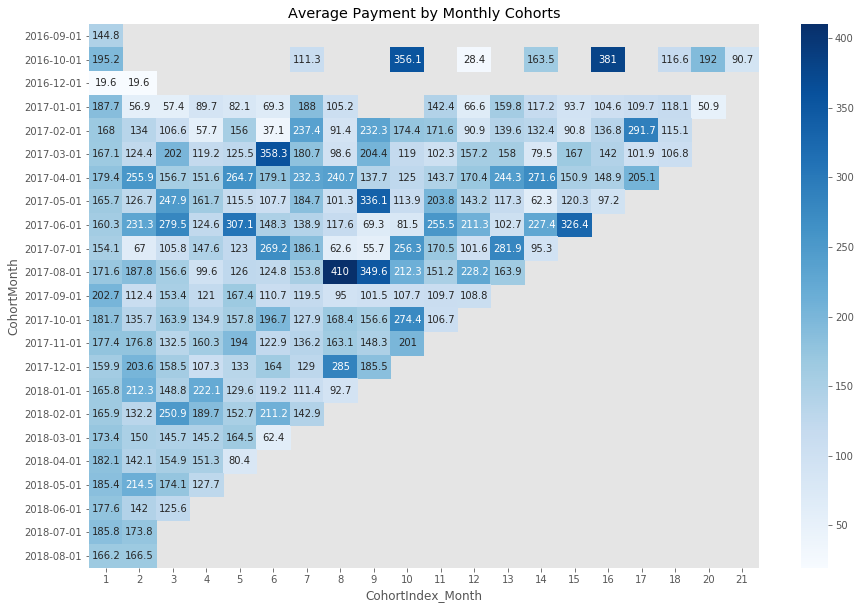

In [15]:
# --- calculate average payment ---
# Group customers based on the cohort month and index month
monthly_grouping = olist_data_clean.groupby(['CohortMonth','CohortIndex_Month'])

# Calculate the average of the unit price column
monthly_cohort_payment = monthly_grouping['payment_value'].mean()

# Reset the index of cohort_data
monthly_cohort_payment = monthly_cohort_payment.reset_index()

# Create a pivot 
monthly_average_payment = monthly_cohort_payment.pivot(index='CohortMonth', 
                                                       columns='CohortIndex_Month',
                                                       values='payment_value')

# --- visualize average payment by monthly cohorts ---
# Initialize an 8 by 6 inches plot figure
plt.figure(figsize=(15, 10))

# Add a title
plt.title('Average Payment by Monthly Cohorts')

# Create the heatmap
sns.heatmap(monthly_average_payment.round(1), annot=True, cmap='Blues', fmt='g')
plt.show()

### Cohort Analysis - Monthly Retention Rate ###
1. How many customers originally in each cohort?
2. How many of them were active in following months?

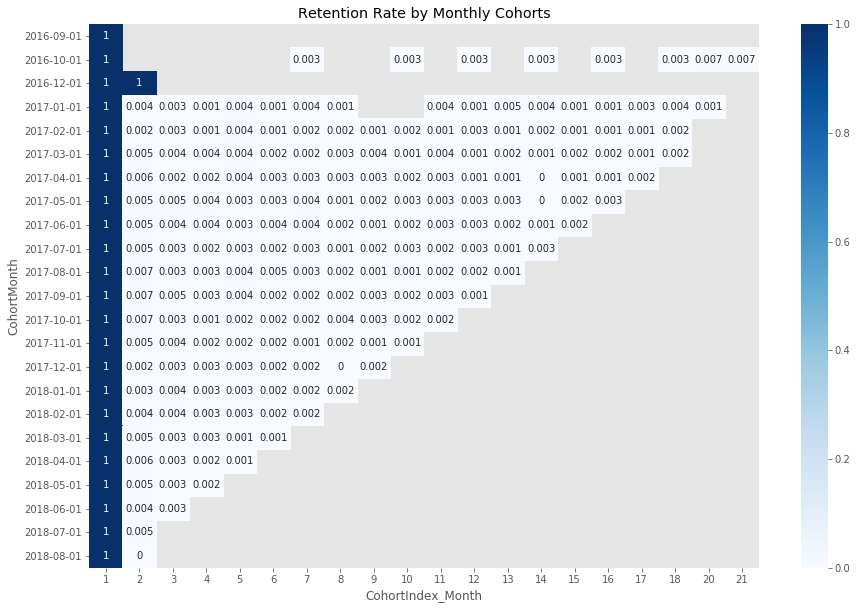

In [16]:
# --- calculate retention rate from scratch ---
# Count the number of unique values per customer_unique_id
monthly_cohort_data = monthly_grouping['customer_unique_id'].apply(pd.Series.nunique).reset_index()

# Convert the CohortMonth as object:
convert_dt_as_date_object(monthly_cohort_data, 'CohortMonth')

# Create a pivot 
monthly_cohort_counts = monthly_cohort_data.pivot(index='CohortMonth', columns='CohortIndex_Month', values='customer_unique_id')

# Extract cohort sizes from the first column of cohort_counts
monthly_cohort_sizes = monthly_cohort_counts.iloc[:,0]

# Calculate retention by dividing the counts with the cohort sizes
monthly_retention = monthly_cohort_counts.divide(monthly_cohort_sizes, axis=0)

del(monthly_cohort_data, monthly_cohort_counts, monthly_cohort_sizes)

# Calculate churn
monthly_churn = 1 - monthly_retention

# --- visualize retention rate by monthly cohorts  ---
# Initialize an 8 by 6 inches plot figure
plt.figure(figsize=(15, 10))

# Add a title
plt.title('Retention Rate by Monthly Cohorts')

# Create the heatmap
sns.heatmap(monthly_retention.round(3), annot=True, cmap='Blues', fmt='g')
plt.show()

## Part 3 - DEVELOP: Customer Lifetime Value ##
Calculate Overall Mean: Retention and Churn Rate
* Given this is the first month the customers have been active, exclude the first month values as they are constant.
* Chaining: monthly mean --> overall mean rates

In [17]:
# --- 8. Customer Lifetime Value ---
# Calculate the mean retention rate
retention_rate = monthly_retention.iloc[:,1:].mean().mean()

# Calculate the mean churn rate
churn_rate = monthly_churn.iloc[:,1:].mean().mean()

# Print rounded retention and churn rates
print('Retention rate: {:.2f}; Churn rate: {:.2f}'.format(retention_rate, churn_rate))

Retention rate: 0.01; Churn rate: 0.99


### Customer Lifetime Value Formulas ###

**NOTE 1: each formula has its own limitations where it does not account for**
* Tenure, retention and churn
* new customer and their future revenue
* However, the most popular method is Traditional CLV where it accounts for customer loyalty!

**NOTE 2: for simplicity, ignored the profit margin from the CLV calculations since it is not known to us.**

* **Basic CLV** =  Monthly Revenue * Lifespan Months
* **Granular CLV** = Revenue/Purchase * Frequency/Month * Lifespan Months
* **Traditional CLV** = Monthly Revenue * (Retention Rate / Churn Rate)

In [18]:
# --- calculate basic CLV ---
# Calculate monthly spend per customer
monthly_revenue = olist_data_clean.groupby(['customer_unique_id','PurchaseMonth'])['payment_value'].sum()

# Calculate average monthly spend
monthly_revenue = np.mean(monthly_revenue)

# Define lifespan to 21 months based on the order purchase period
lifespan_months = 21

# Calculate basic CLV
clv_basic = monthly_revenue * lifespan_months

# Print the basic CLV value: currency conversion 1 Real = 0.26 CAD
print('Average basic CLV is {:.1f} CAD'.format(clv_basic * 0.26))

# --- calculate granular CLV ---
# Calculate average revenue per invoice
revenue_per_purchase = olist_data_clean.groupby(['order_id'])['payment_value'].mean().mean()

# Calculate average number of unique orders per customer per month
frequency_per_month = olist_data_clean.groupby(['customer_unique_id','PurchaseMonth'])['order_id'].nunique().mean()

# Calculate granular CLV
clv_granular = revenue_per_purchase * frequency_per_month * lifespan_months

# Print the granular CLV value: currency conversion 1 Real = 0.26 CAD
print('Average granular CLV is {:.1f} CAD'.format(clv_granular * 0.26))

# --- calculate traditional CLV ---
# Calculate monthly spend per customer
monthly_revenue = olist_data_clean.groupby(['customer_unique_id','PurchaseMonth'])['payment_value'].sum().mean()

# Calculate average monthly retention rate
retention_rate = monthly_retention.iloc[:,1:].mean().mean()

# Calculate average monthly churn rate
churn_rate = 1 - retention_rate

# Calculate traditional CLV 
clv_traditional = monthly_revenue * (retention_rate / churn_rate)

# Print traditional CLV and the retention rate values: currency conversion 1 Real = 0.26 CAD
print('Average traditional CLV is {:.1f} CAD at {:.1f} % retention_rate'.format(clv_traditional * 0.26, retention_rate*100))

Average basic CLV is 1139.7 CAD
Average granular CLV is 37.2 CAD
Average traditional CLV is 0.3 CAD at 0.5 % retention_rate


In [19]:
# --- define a set of features ---
# Define the snapshot date as the latest PurchaseMonth
snapshot_dt = datetime(2018,8,1)

# Explore the monthly distribution of transactions
olist_data_clean.groupby(['PurchaseMonth']).size()

# Exclude target variable
olist_data_clean_X = olist_data_clean[olist_data_clean['order_purchase_date'].dt.strftime('%Y-%m') != '2018-08']

# Prepare the features dataframe based on unique CustomerID
features = olist_data_clean_X.groupby('customer_unique_id').agg({
  'order_purchase_date': lambda x: (snapshot_dt - x.max()).days,
  # Calculate frequency by counting unique number of orders
  'order_id': pd.Series.nunique,
  # Calculate monetary value by summing all payment values
  'payment_value': np.sum,
  # Calculate number of order items
  'order_item_id': 'count',
  # Calculate number of products
  'product_id': 'count'}).reset_index()

# Rename the columns
features.columns = ['CustomerID', 'recency', 'frequency', 'monetary', 'items_count', 'products_count']

# Replace NaN with 0 in this context
features.recency = np.where(features.recency.isnull(), 0, features.recency)

In [20]:
# --- define target variable ---
# Build a pivot table with monthly orders per customer
cust_month_orders = pd.pivot_table(data=olist_data_clean, values='order_id',
                               index=['customer_unique_id'], columns=['PurchaseMonth'],
                               aggfunc=pd.Series.nunique, fill_value=0)

# Delete '2019-09-01' data from cust_month_orders
cust_month_orders = cust_month_orders.iloc[:, :-1]

# Store August 2018 data column name as a list
target = [pd.to_datetime('2018-08-01').date()]

# Store target value as `Y`
Y = cust_month_orders[target]

# --- split data into training and test sets ---
# Store customer identifier column name as a list
custid = 'CustomerID'

# Select feature column names excluding customer identifier
cols = [col for col in features.columns if col not in custid]

# Split data to training and testing
X_train, X_val, y_train, y_val = train_test_split(features, Y, test_size=0.25, random_state=99)
    
# Subset customer_id for X_val:
X_cust_id_val = X_val[custid]

# Extract the features on X_train and X_val:
X_train, X_val  = X_train[cols], X_val[cols]

In [21]:
# --- predict next month orders ---
# Create a model instance
baseline = LinearRegression()

# Compute mean absolute error
baseline_cv_mae = cross_val_score(baseline, X_train, y_train,
                              cv=5, scoring='neg_mean_absolute_error')
baseline_mae = -1 * baseline_cv_mae
baseline_mean_mae = np.mean(baseline_mae)

# Compute mean root mean squared error
baseline_cv_mse = cross_val_score(baseline, X_train, y_train,
                              cv=5, scoring='neg_mean_squared_error')
baseline_rmse = np.sqrt(-1 * baseline_cv_mse)
baseline_mean_rmse  = np.mean(baseline_rmse)

print('Baseline MAE: {}; Baseline RMSE: {}'.format(str(baseline_mean_mae), str(baseline_mean_rmse)))

Baseline MAE: 0.08682752154643096; Baseline RMSE: 0.15799144157415865


In [22]:
# --- 15. Create models --- # 
# initialize model list and dicts
models = []
mean_mae = {}
cv_std = {}
res = {}

# define common model parameters: num processors and shared model parameters
n_proc = 1
verbose_lv = 5

# # create and tune the models that you brainstormed during part 2
# ###############################################################################        
# # Hyper-parameters tuning: RandomForest
# rf = RandomForestRegressor()   
# n_iter = 10
# param_dist_rf = {'n_estimators':sp.randint(10,50), 
#                   'max_depth':sp.randint(1,10),
#                   'min_samples_split':sp.randint(10,60)}

# random_search_rf = model_tuning_param(rf, X_train, y_train, param_dist_rf, n_iter)    
    
# # print the best model parameters: RandomForest    
# param_1 = 'n_estimators' 
# param_2 = 'max_depth'
# param_3 = 'min_samples_split'
    
# print_best_params(random_search_rf, param_1, param_2, param_3)
# ###############################################################################    

# # Hyper-parameters tuning: GradientBoosting
# gbr = GradientBoostingRegressor()
# n_iter = 10
# param_dist_gbr = {'n_estimators':sp.randint(10,40), 
#                   'max_depth':sp.randint(1,20),
#                   'loss':['ls']}

# random_search_gbr = model_tuning_param(gbr, X_train, y_train, param_dist_gbr, n_iter)    
    
# # print the best model parameters: GradientBoosting    
# param_1 = 'n_estimators' 
# param_2 = 'max_depth'
# param_3 = 'loss'
    
# print_best_params(random_search_gbr, param_1, param_2, param_3)        
# ###############################################################################    

# # Hyper-parameters tuning: XGBoost
# xgb = XGBRegressor()   
# n_iter = 10
# param_dist_xgb = {'n_estimators':sp.randint(10,40), 
#                   'max_depth':sp.randint(1,20),
#                   'learning_rate':np.random.uniform(0,1,10)}

# random_search_xgb = model_tuning_param(xgb, X_train, y_train, param_dist_xgb, n_iter)    
    
# # print the best model parameters: XGBRegressor    
# param_1 = 'n_estimators' 
# param_2 = 'max_depth'
# param_3 = 'learning_rate'
    
# print_best_params(random_search_xgb, param_1, param_2, param_3)

In [23]:
# --- 16. Cross-validate models --- # 
# do 2-fold cross validation on models and measure MAE
# Model List to train: Order of Model Complexity
lr_L1 = Lasso(alpha=0.01)
lr_L2 = Ridge(alpha=0.01)
rf = RandomForestRegressor(n_estimators=32, n_jobs=n_proc, max_depth=5,
                               min_samples_split=26, verbose=verbose_lv)   
gbr = GradientBoostingRegressor(n_estimators=29, max_depth=2, loss='ls', verbose=verbose_lv)
xgb = XGBRegressor(n_estimators=23, max_depth=2, learning_rate=0.5436747777101026) 

# a list of regressors:
models.extend([lr_L1, lr_L2, rf, gbr, xgb])    

# cross-validate models, using MAE to evaluate and print the summaries
print("begin cross-validation")
for model in models:
    model_train(model, X_train, y_train, n_proc, mean_mae, cv_std)
    model_summary(model, mean_mae, cv_std)

begin cross-validation

Model:
 Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
Average MAE:
 0.09552242479786738
Std. Dev during CV:
 0.0010099892239464133

Model:
 Ridge(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
Average MAE:
 0.08682760467180098
Std. Dev during CV:
 0.0009978658570779354


C:\Users\yoots\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


building tree 1 of 32
building tree 2 of 32
building tree 3 of 32
building tree 4 of 32
building tree 5 of 32
building tree 6 of 32
building tree 7 of 32
building tree 8 of 32
building tree 9 of 32
building tree 10 of 32
building tree 11 of 32
building tree 12 of 32
building tree 13 of 32
building tree 14 of 32
building tree 15 of 32
building tree 16 of 32
building tree 17 of 32
building tree 18 of 32
building tree 19 of 32
building tree 20 of 32
building tree 21 of 32
building tree 22 of 32
building tree 23 of 32
building tree 24 of 32
building tree 25 of 32
building tree 26 of 32
building tree 27 of 32
building tree 28 of 32
building tree 29 of 32
building tree 30 of 32
building tree 31 of 32
building tree 32 of 32


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.0s finished
C:\Users\yoots\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Paralle

building tree 1 of 32
building tree 2 of 32
building tree 3 of 32
building tree 4 of 32
building tree 5 of 32
building tree 6 of 32
building tree 7 of 32
building tree 8 of 32
building tree 9 of 32
building tree 10 of 32
building tree 11 of 32
building tree 12 of 32
building tree 13 of 32
building tree 14 of 32
building tree 15 of 32
building tree 16 of 32
building tree 17 of 32
building tree 18 of 32
building tree 19 of 32
building tree 20 of 32
building tree 21 of 32
building tree 22 of 32
building tree 23 of 32
building tree 24 of 32
building tree 25 of 32
building tree 26 of 32
building tree 27 of 32
building tree 28 of 32
building tree 29 of 32
building tree 30 of 32
building tree 31 of 32
building tree 32 of 32


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.0s finished
C:\Users\yoots\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Paralle

building tree 1 of 32
building tree 2 of 32
building tree 3 of 32
building tree 4 of 32
building tree 5 of 32
building tree 6 of 32
building tree 7 of 32
building tree 8 of 32
building tree 9 of 32
building tree 10 of 32
building tree 11 of 32
building tree 12 of 32
building tree 13 of 32
building tree 14 of 32
building tree 15 of 32
building tree 16 of 32
building tree 17 of 32
building tree 18 of 32
building tree 19 of 32
building tree 20 of 32
building tree 21 of 32
building tree 22 of 32
building tree 23 of 32
building tree 24 of 32
building tree 25 of 32
building tree 26 of 32
building tree 27 of 32
building tree 28 of 32
building tree 29 of 32
building tree 30 of 32
building tree 31 of 32
building tree 32 of 32


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.0s finished
C:\Users\yoots\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Paralle

building tree 1 of 32
building tree 2 of 32
building tree 3 of 32
building tree 4 of 32
building tree 5 of 32
building tree 6 of 32
building tree 7 of 32
building tree 8 of 32
building tree 9 of 32
building tree 10 of 32
building tree 11 of 32
building tree 12 of 32
building tree 13 of 32
building tree 14 of 32
building tree 15 of 32
building tree 16 of 32
building tree 17 of 32
building tree 18 of 32
building tree 19 of 32
building tree 20 of 32
building tree 21 of 32
building tree 22 of 32
building tree 23 of 32
building tree 24 of 32
building tree 25 of 32
building tree 26 of 32
building tree 27 of 32
building tree 28 of 32
building tree 29 of 32
building tree 30 of 32
building tree 31 of 32
building tree 32 of 32


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.0s finished
C:\Users\yoots\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Paralle

building tree 1 of 32
building tree 2 of 32
building tree 3 of 32
building tree 4 of 32
building tree 5 of 32
building tree 6 of 32
building tree 7 of 32
building tree 8 of 32
building tree 9 of 32
building tree 10 of 32
building tree 11 of 32
building tree 12 of 32
building tree 13 of 32
building tree 14 of 32
building tree 15 of 32
building tree 16 of 32
building tree 17 of 32
building tree 18 of 32
building tree 19 of 32
building tree 20 of 32
building tree 21 of 32
building tree 22 of 32
building tree 23 of 32
building tree 24 of 32
building tree 25 of 32
building tree 26 of 32
building tree 27 of 32
building tree 28 of 32
building tree 29 of 32
building tree 30 of 32
building tree 31 of 32
building tree 32 of 32

Model:
 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=5, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min

[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.0s finished
C:\Users\yoots\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


      Iter       Train Loss   Remaining Time 
         1           0.0528            0.44s
         2           0.0432            0.63s
         3           0.0354            0.68s
         4           0.0291            0.68s
         5           0.0240            0.67s
         6           0.0198            0.66s
         7           0.0165            0.59s
         8           0.0138            0.60s
         9           0.0116            0.56s
        10           0.0098            0.51s
        11           0.0084            0.49s
        12           0.0072            0.47s
        13           0.0062            0.44s
        14           0.0055            0.44s
        15           0.0049            0.42s
        16           0.0043            0.39s
        17           0.0039            0.35s
        18           0.0036            0.32s
        19           0.0033            0.30s
        20           0.0031            0.27s
        21           0.0030            0.24s
        2

C:\Users\yoots\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


      Iter       Train Loss   Remaining Time 
         1           0.0527            0.87s
         2           0.0430            0.84s
         3           0.0352            0.81s
         4           0.0289            0.68s
         5           0.0238            0.67s
         6           0.0197            0.66s
         7           0.0163            0.70s
         8           0.0136            0.69s
         9           0.0114            0.63s
        10           0.0096            0.63s
        11           0.0082            0.57s
        12           0.0070            0.55s
        13           0.0061            0.50s
        14           0.0053            0.46s
        15           0.0047            0.43s
        16           0.0042            0.40s
        17           0.0038            0.37s
        18           0.0035            0.34s
        19           0.0032            0.31s
        20           0.0030            0.27s
        21           0.0028            0.24s
        2

C:\Users\yoots\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


      Iter       Train Loss   Remaining Time 
         1           0.0523            0.87s
         2           0.0428            0.84s
         3           0.0350            0.68s
         4           0.0287            0.68s
         5           0.0236            0.67s
         6           0.0195            0.66s
         7           0.0162            0.68s
         8           0.0135            0.67s
         9           0.0113            0.63s
        10           0.0095            0.60s
        11           0.0081            0.56s
        12           0.0069            0.53s
        13           0.0059            0.50s
        14           0.0052            0.48s
        15           0.0046            0.44s
        16           0.0041            0.40s
        17           0.0037            0.37s
        18           0.0033            0.34s
        19           0.0031            0.30s
        20           0.0028            0.27s
        21           0.0027            0.24s
        2

C:\Users\yoots\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


      Iter       Train Loss   Remaining Time 
         1           0.0520            0.87s
         2           0.0425            0.63s
         3           0.0348            0.81s
         4           0.0286            0.68s
         5           0.0235            0.67s
         6           0.0194            0.66s
         7           0.0161            0.64s
         8           0.0134            0.61s
         9           0.0113            0.58s
        10           0.0095            0.53s
        11           0.0081            0.51s
        12           0.0069            0.48s
        13           0.0060            0.46s
        14           0.0052            0.43s
        15           0.0046            0.40s
        16           0.0041            0.36s
        17           0.0037            0.34s
        18           0.0034            0.31s
        19           0.0031            0.28s
        20           0.0029            0.26s
        21           0.0028            0.22s
        2

C:\Users\yoots\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


      Iter       Train Loss   Remaining Time 
         1           0.0535            0.87s
         2           0.0437            0.63s
         3           0.0358            0.68s
         4           0.0294            0.68s
         5           0.0243            0.67s
         6           0.0201            0.60s
         7           0.0167            0.59s
         8           0.0139            0.61s
         9           0.0117            0.58s
        10           0.0099            0.53s
        11           0.0084            0.51s
        12           0.0072            0.48s
        13           0.0063            0.46s
        14           0.0055            0.42s
        15           0.0049            0.39s
        16           0.0044            0.37s
        17           0.0040            0.34s
        18           0.0036            0.31s
        19           0.0033            0.28s
        20           0.0031            0.25s
        21           0.0029            0.22s
        2

In [24]:
# --- 17. Select the best model with lowest MAE for your prediction model --- #
# Best Model RandomForest: MAE = 0.00395, CV_STD_MAE = 0.000244     
model = min(mean_mae, key=mean_mae.get)
print('\nBest model with the lowest MAE:')
print(model)


Best model with the lowest MAE:
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.5436747777101026,
             max_delta_step=0, max_depth=2, min_child_weight=1, missing=None,
             n_estimators=23, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)


### Model Evaluation Summary by MAE ###
Here is the summarized results of all five models evaluated by a Mean-Absolute-Error (MAE).

**1) L1 Lasso Regressor**
* Avg. MAE Train: 0.0955 +/- 0.001

**2) L2 Ridge Regressor**
* Avg. MAE Train: 0.0868 +/- 0.0009

**3) RandomForest Regressor**
* Avg. MAE Train: 0.000395 +/- 0.00024

**4) GradientBoosting Regressor**
* Avg. MAE Train: 0.000914 +/- 0.00032

**5) XGBoost Regressor**
* Avg. MAE Train: 0.000397 +/- 0.00022

[01:35:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


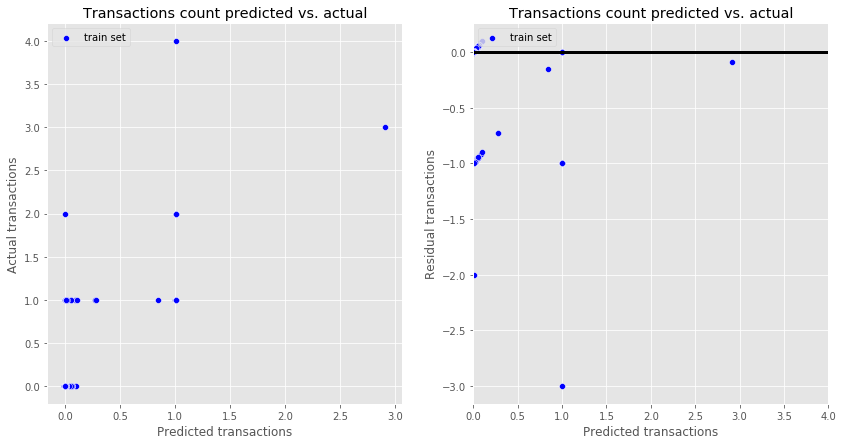

In [25]:
# --- 18. Model Evaluation: Scatter Plot --- #
# re-train a model with best model:
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train).reshape(len(y_train),1)
y_train_pred = pd.DataFrame(y_train_pred, columns=['2018-08-01'])

# Plot a comparison scatter plot: predicted vs. actual
plt.figure(figsize=(14,7))
plt.subplots_adjust(wspace=0.2)
plt.subplot(1,2,1)
plot_reg_compare(y_train_pred.values, y_train.values)
plt.title('Transactions count predicted vs. actual')

# Plot a residual scatter plot: predicted vs. actual
plt.subplot(1,2,2)
plot_reg_residual(y_train_pred.values, y_train.values)
plt.title('Transactions count predicted vs. actual')
plt.show()

## Part 4 - DEPLOY ##

In [26]:
# --- 19. Save Prediction Results ---
# make predictions on a validation set
df_pred = model.predict(X_val)

# save it as a dataframe:
results = pd.DataFrame({'customer_unique_id': X_cust_id_val,
                      'unique_orders':df_pred})

# save model results as .csv file:
results.to_csv('pred_unique_orders_rf.csv', index=False, index_label=None)